<a href="https://colab.research.google.com/github/DianaDoosti/Introduction_to_AI_2025/blob/main/AI4032_MP2/MP2_Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [14]:
# Get cpu, gpu or mps device for training.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

device: cpu


## **1. Data Preparation**

## Loading the raw data

In [15]:
import gdown

file_id = '1Wq1mvwBnq8us9xhDs4W_Rz-R0hDQWHMQ'
url = f'https://drive.google.com/uc?id={file_id}'

# download to local filename
output = 'weatherdata.csv'
gdown.download(url, output, quiet=False)

data = pd.read_csv('weatherdata.csv')
print(data.head())

Downloading...
From: https://drive.google.com/uc?id=1Wq1mvwBnq8us9xhDs4W_Rz-R0hDQWHMQ
To: /content/weatherdata.csv
100%|██████████| 2.77M/2.77M [00:00<00:00, 146MB/s]

       DATE  MONTH  BASEL_cloud_cover  BASEL_humidity  BASEL_pressure  \
0  20000101      1                  8            0.89          1.0286   
1  20000102      1                  8            0.87          1.0318   
2  20000103      1                  5            0.81          1.0314   
3  20000104      1                  7            0.79          1.0262   
4  20000105      1                  5            0.90          1.0246   

   BASEL_global_radiation  BASEL_precipitation  BASEL_sunshine  \
0                    0.20                 0.03             0.0   
1                    0.25                 0.00             0.0   
2                    0.50                 0.00             3.7   
3                    0.63                 0.35             6.9   
4                    0.51                 0.07             3.7   

   BASEL_temp_mean  BASEL_temp_min  ...  STOCKHOLM_temp_min  \
0              2.9             1.6  ...                -9.3   
1              3.6             2.7  ..

#Extracting french cities' parameters

In [16]:
columns_to_select = np.r_[0 , 1 , 96:104 , 126:134 , 157:165]
data = data.iloc[:, columns_to_select]

print(data.head())
print(data.shape)

       DATE  MONTH  MONTELIMAR_wind_speed  MONTELIMAR_humidity  \
0  20000101      1                    3.8                 0.85   
1  20000102      1                    5.8                 0.82   
2  20000103      1                    0.4                 0.92   
3  20000104      1                    1.1                 0.85   
4  20000105      1                    3.4                 0.82   

   MONTELIMAR_pressure  MONTELIMAR_global_radiation  MONTELIMAR_precipitation  \
0               1.0269                         0.30                       0.0   
1               1.0287                         0.54                       0.0   
2               1.0316                         0.53                       0.0   
3               1.0274                         0.64                       0.0   
4               1.0234                         0.70                       0.0   

   MONTELIMAR_temp_mean  MONTELIMAR_temp_min  MONTELIMAR_temp_max  ...  \
0                   5.5                  2

# Preprocessong : Normalization

In [17]:
dates_month = data.iloc[:, :2]
parameters = data.iloc[:, 2:]


def normalize_columns(arr):
    # Compute the min and max for each column
    col_min = arr.min(axis=0)
    col_max = arr.max(axis=0)

    # Apply normalization per column
    normalized = (arr - col_min) / (col_max - col_min)

    return normalized

normalized_parameters = normalize_columns(parameters)

# normalized data
df = pd.concat([dates_month, normalized_parameters], axis=1)

print(df.head())
print(df.shape)

       DATE  MONTH  MONTELIMAR_wind_speed  MONTELIMAR_humidity  \
0  20000101      1               0.287879             0.796875   
1  20000102      1               0.439394             0.750000   
2  20000103      1               0.030303             0.906250   
3  20000104      1               0.083333             0.796875   
4  20000105      1               0.257576             0.750000   

   MONTELIMAR_pressure  MONTELIMAR_global_radiation  MONTELIMAR_precipitation  \
0             0.775238                     0.077348                       0.0   
1             0.809524                     0.143646                       0.0   
2             0.864762                     0.140884                       0.0   
3             0.784762                     0.171271                       0.0   
4             0.708571                     0.187845                       0.0   

   MONTELIMAR_temp_mean  MONTELIMAR_temp_min  MONTELIMAR_temp_max  ...  \
0              0.272989             0.3353

# Preparing data for the model

In [18]:
# Window and overlap settings
window_size = 36
input_dim = 24
output_dim = 8  # TOURS parameters


# Convert DATE column to datetime for easier access
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y%m%d')

# Separate train and test data based on year
train_data = df[df['DATE'].dt.year != 2009]
test_data = df[df['DATE'].dt.year == 2009]

def create_windows(data, window_size):
    X, y = [], []
    step = 1
    for i in range(0, len(data) - window_size, step):
        window = data.iloc[i:i + window_size, 2:].values  # Exclude DATE and MONTH
        target = data.iloc[i + window_size, -8:].values  # TOURS parameters
        X.append(window)
        y.append(target)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Create training and testing windows
X_train, y_train = create_windows(train_data, window_size)
X_test, y_test = create_windows(test_data, window_size)

print(f'Train shape: {X_train.shape}, Test shape: {X_test.shape}')


print("Checking for NaN values in training data:", torch.isnan(X_train).any(), torch.isnan(y_train).any())
print("Checking for Inf values in training data:", torch.isinf(X_train).any(), torch.isinf(y_train).any())

Train shape: torch.Size([3253, 36, 24]), Test shape: torch.Size([329, 36, 24])
Checking for NaN values in training data: tensor(False) tensor(False)
Checking for Inf values in training data: tensor(False) tensor(False)


# **2. Model 1 : one hidden layer**

# Model 1 definition

In [19]:
class RegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(window_size * input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate model
model = RegressionModel().to(device)
print(model)

# Training Parameters
n_epochs = 200
batch_size = 500
learning_rates = [1, 1e-3, 1e-8]

RegressionModel(
  (fc1): Linear(in_features=864, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=8, bias=True)
)


# Implementation of Model 1

Training with learning rate: 1
Epoch 50/200, Train Loss: 0.0116, Test Loss: 0.0135
Epoch 100/200, Train Loss: 0.0111, Test Loss: 0.0116
Epoch 150/200, Train Loss: 0.0106, Test Loss: 0.0111
Epoch 200/200, Train Loss: 0.0102, Test Loss: 0.0108


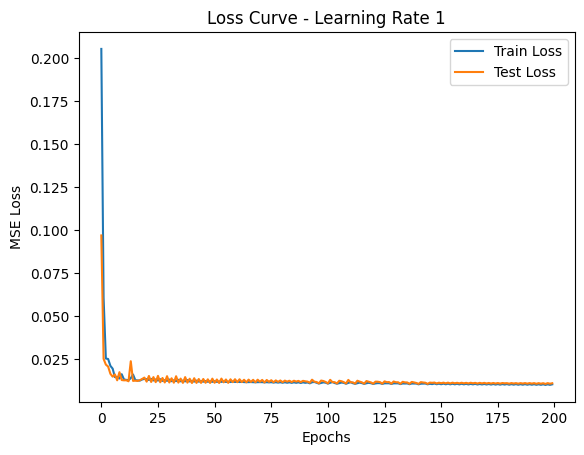

Training with learning rate: 0.001
Epoch 50/200, Train Loss: 0.0097, Test Loss: 0.0098
Epoch 100/200, Train Loss: 0.0094, Test Loss: 0.0096
Epoch 150/200, Train Loss: 0.0093, Test Loss: 0.0095
Epoch 200/200, Train Loss: 0.0093, Test Loss: 0.0095


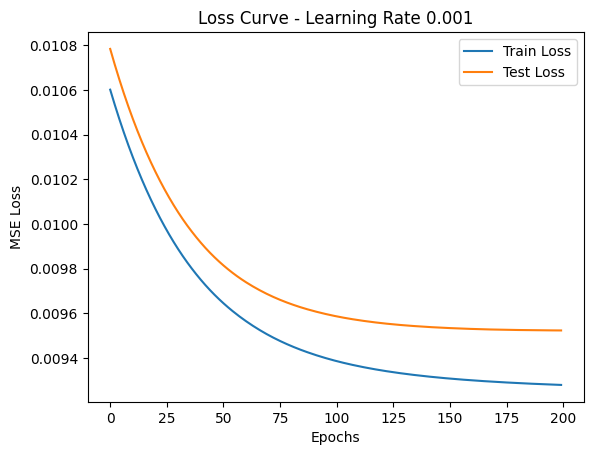

Training with learning rate: 1e-08
Epoch 50/200, Train Loss: 0.0093, Test Loss: 0.0095
Epoch 100/200, Train Loss: 0.0093, Test Loss: 0.0095
Epoch 150/200, Train Loss: 0.0093, Test Loss: 0.0095
Epoch 200/200, Train Loss: 0.0093, Test Loss: 0.0095


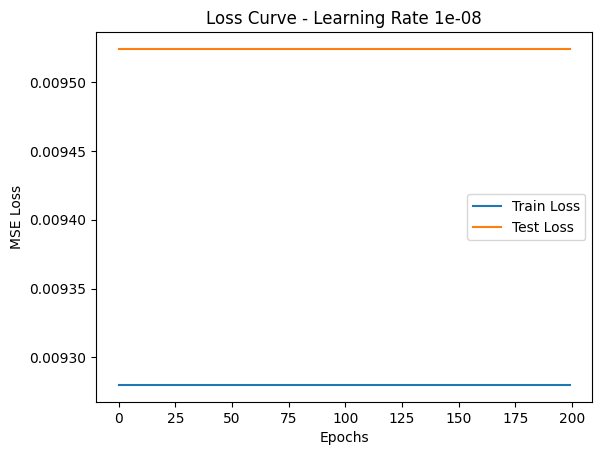

In [20]:
# Training Loop for different learning rates
for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_losses, val_losses = [], []

    for epoch in range(n_epochs):
        model.train()
        epoch_train_loss = 0.0

        for b in range(0, X_train.shape[0], batch_size):
            X_batch = X_train[b:b+batch_size].to(device)
            y_batch = y_train[b:b+batch_size].to(device)

            # Forward pass
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item() * X_batch.size(0)

        # Testing
        model.eval()
        with torch.no_grad():
            test_predictions = model(X_test.to(device))
            test_loss = criterion(test_predictions, y_test.to(device))

        # Record losses
        train_losses.append(epoch_train_loss / len(X_train))
        val_losses.append(test_loss.item())

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch + 1}/{n_epochs}, Train Loss: {epoch_train_loss / len(X_train):.4f}, Test Loss: {test_loss.item():.4f}")

    # Plotting the loss curve for the current learning rate
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Test Loss')
    plt.title(f"Loss Curve - Learning Rate {lr}")
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()


# **3. Model 2 : two hidden layers**

# Model 2 definition

In [21]:
class RegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(window_size * input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = nn.ReLU()(self.fc3(x))
        x = self.fc4(x)
        return x

# Instantiate model
model = RegressionModel().to(device)
print(model)

# Training Parameters
n_epochs = 200
batch_size = 500
learning_rates = [1, 1e-3, 1e-8]

RegressionModel(
  (fc1): Linear(in_features=864, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=8, bias=True)
)


# Implementation of Model 2

Training with learning rate: 1
Epoch 50/200, Train Loss: 0.0100, Test Loss: 0.0105
Epoch 100/200, Train Loss: 0.0098, Test Loss: 0.0106
Epoch 150/200, Train Loss: 0.0094, Test Loss: 0.0106
Epoch 200/200, Train Loss: 0.0092, Test Loss: 0.0095


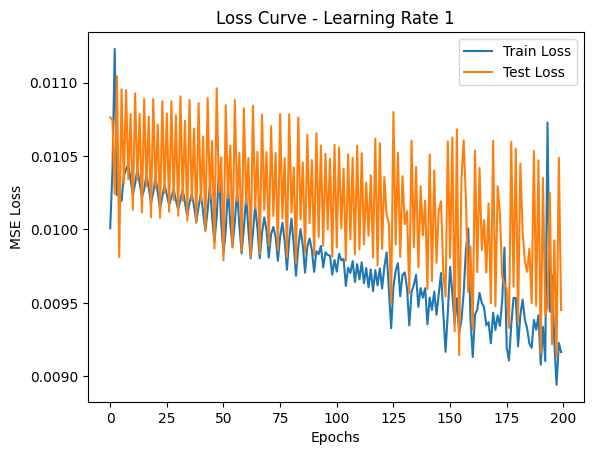

Training with learning rate: 0.001
Epoch 50/200, Train Loss: 0.0087, Test Loss: 0.0090
Epoch 100/200, Train Loss: 0.0086, Test Loss: 0.0089
Epoch 150/200, Train Loss: 0.0085, Test Loss: 0.0089
Epoch 200/200, Train Loss: 0.0085, Test Loss: 0.0090


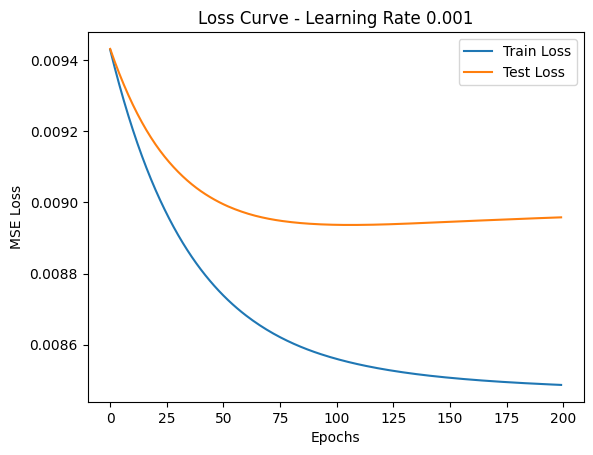

Training with learning rate: 1e-08
Epoch 50/200, Train Loss: 0.0085, Test Loss: 0.0090
Epoch 100/200, Train Loss: 0.0085, Test Loss: 0.0090
Epoch 150/200, Train Loss: 0.0085, Test Loss: 0.0090
Epoch 200/200, Train Loss: 0.0085, Test Loss: 0.0090


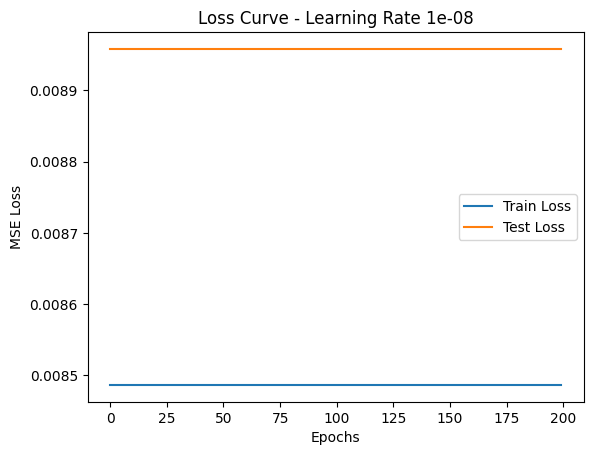

In [23]:
# Training Loop for different sample rates
for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_losses, val_losses = [], []

    for epoch in range(n_epochs):
        model.train()
        epoch_train_loss = 0.0

        for b in range(0, X_train.shape[0], batch_size):
            X_batch = X_train[b:b+batch_size].to(device)
            y_batch = y_train[b:b+batch_size].to(device)

            # Forward pass
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item() * X_batch.size(0)

        # Testing
        model.eval()
        with torch.no_grad():
            test_predictions = model(X_test.to(device))
            test_loss = criterion(test_predictions, y_test.to(device))

        # Record losses
        train_losses.append(epoch_train_loss / X_train.size(0))
        val_losses.append(test_loss.item())

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch + 1}/{n_epochs}, Train Loss: {epoch_train_loss / len(X_train):.4f}, Test Loss: {test_loss.item():.4f}")

    # Plotting the loss curve for the current learning rate
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Test Loss')
    plt.title(f"Loss Curve - Learning Rate {lr}")
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()
